In [90]:
import pandas as pd

real_path = "C:\\Users\\edugj\\PROGRAMACAO\\turing\\projetoTA\\dataset\\halfhourly_dataset\\halfhourly_dataset\\block_0.csv"

df = pd.read_csv(real_path)

In [91]:
df = df[df['energy(kWh/hh)'] != 'Null']

In [92]:
df.dropna(inplace=True)
df['tstp'] = pd.to_datetime(df['tstp'])
df['energy(kWh/hh)'] = pd.to_numeric(df['energy(kWh/hh)'])
df_agrupado = df.groupby('tstp', as_index=True)['energy(kWh/hh)'].sum().sort_index()

In [93]:
df_agrupado.sort_index(inplace=True)

In [94]:
df_agrupado = df_agrupado.to_frame()

In [95]:
df_agrupado['energy(kWh/hh)'].dtypes

dtype('float64')

<Axes: xlabel='tstp'>

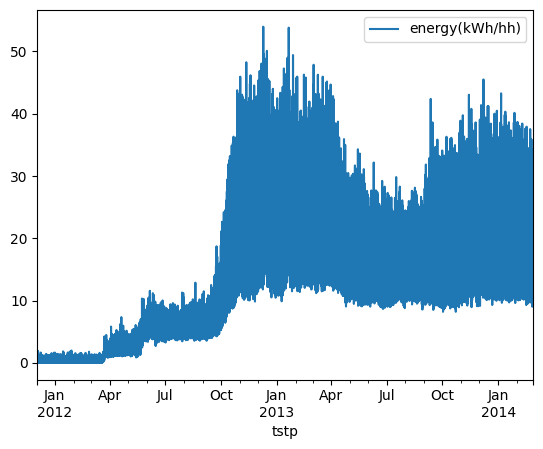

In [96]:
df_agrupado.plot()

In [97]:
df_defato = df_agrupado.loc['2012-10-01':].copy()

<Axes: xlabel='tstp'>

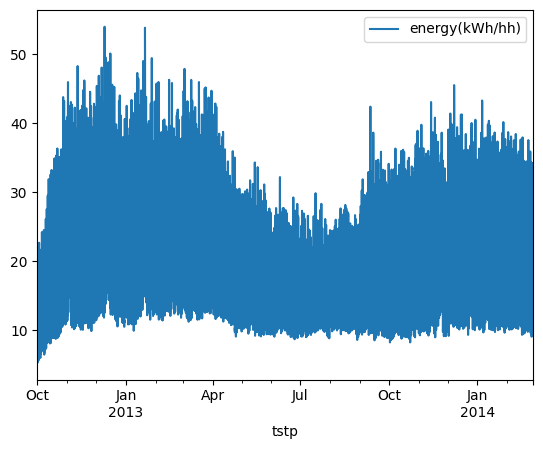

In [98]:
df_defato.plot()

<Axes: xlabel='tstp'>

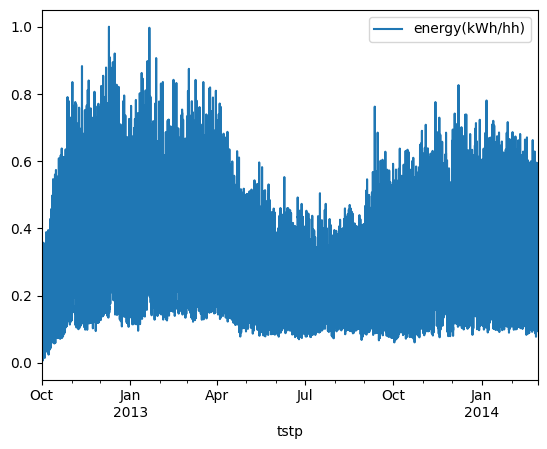

In [99]:
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score

def normalize_data(df2):
    scaler = MinMaxScaler()
    dados_normalizados = scaler.fit_transform(df2['energy(kWh/hh)'].values.reshape(-1,1))
    df2['energy(kWh/hh)'] = dados_normalizados
    return df2, scaler


df_norm, scaler=normalize_data(df_defato)


df_norm.plot()

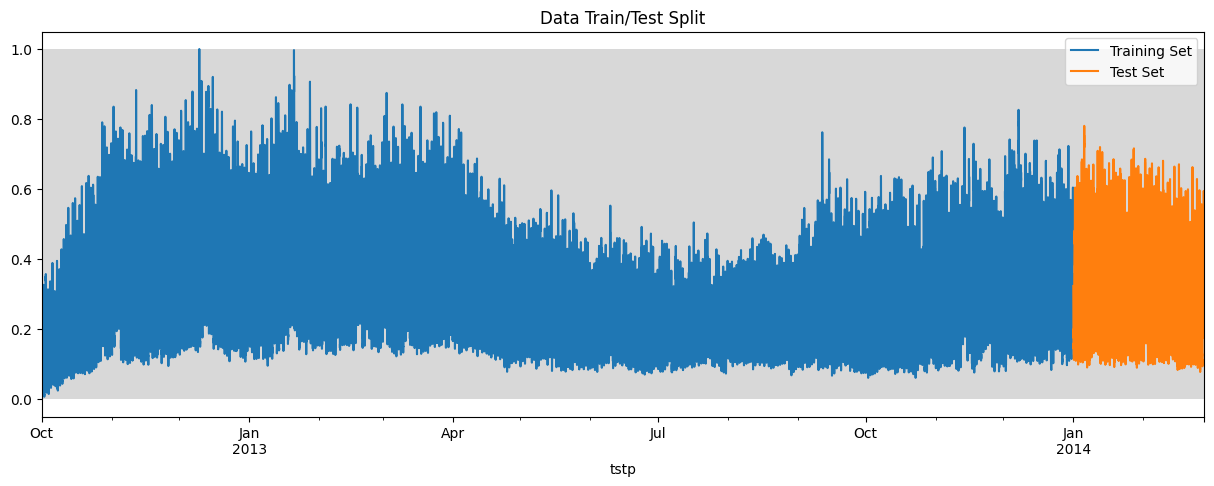

In [100]:
data_split = '2014-01-01'

train = df_norm.loc[df_norm.index < data_split].copy()
test = df_norm.loc[df_norm.index >= data_split].copy()

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.legend(['Training Set', 'Test Set'])
plt.axhspan(0, 1, facecolor='gray', alpha=0.3)
plt.show()

In [101]:
import torch
import numpy as np
import torch.nn as nn

In [102]:
def cria_janelas(data, tamanho):
    x = []
    y = []
    for i in range(tamanho, len(data)):
        x_aux=data.iloc[i-tamanho:i,0]
        y_aux=data.iloc[i,0]
        x.append(x_aux)
        y.append(y_aux)
    return np.array(x).astype(np.float32) , np.array(y).astype(np.float32)

train = df_norm.loc[df_norm.index < data_split].copy()
test = df_norm.loc[df_norm.index >= data_split].copy()

tamanho = 30


xtrain , ytrain = cria_janelas(train,tamanho)

xtest, ytest = cria_janelas(test, tamanho)

trainX = torch.tensor(xtrain[:,:,None], dtype=torch.float32)
trainY = torch.tensor(ytrain[:,None], dtype=torch.float32)

testX = torch.tensor(xtest[:,:,None], dtype=torch.float32)
testY = torch.tensor(ytest[:,None], dtype=torch.float32)






In [103]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)
        self.fc   = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, _ = self.lstm(x)          
        out = self.fc(out[:, -1, :])   
        return out 

In [104]:
from torch.utils.data import TensorDataset, DataLoader

batch_size     = 64
num_epochs     = 100
hidden_dim     = 64
learning_rate  = 1e-3
device         = 'cuda' if torch.cuda.is_available() else 'cpu'

train_ds = TensorDataset(trainX, trainY)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, pin_memory=True)

model = LSTMModel(1, hidden_dim, 1, 1).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [105]:
for epoch in range(1, num_epochs + 1):
    model.train()
    epoch_loss = 0.0

    for xb, yb in train_dl:
        xb, yb = xb.to(device), yb.to(device)

        optimizer.zero_grad()
        pred = model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * xb.size(0)

    if epoch % 10 == 0:
        print(f'Epoch {epoch:03d} | loss={epoch_loss/len(train_ds):.5f}')


c:\Users\edugj\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 010 | loss=0.00168
Epoch 020 | loss=0.00152
Epoch 030 | loss=0.00146
Epoch 040 | loss=0.00144
Epoch 050 | loss=0.00141
Epoch 060 | loss=0.00140
Epoch 070 | loss=0.00138
Epoch 080 | loss=0.00136
Epoch 090 | loss=0.00136
Epoch 100 | loss=0.00135


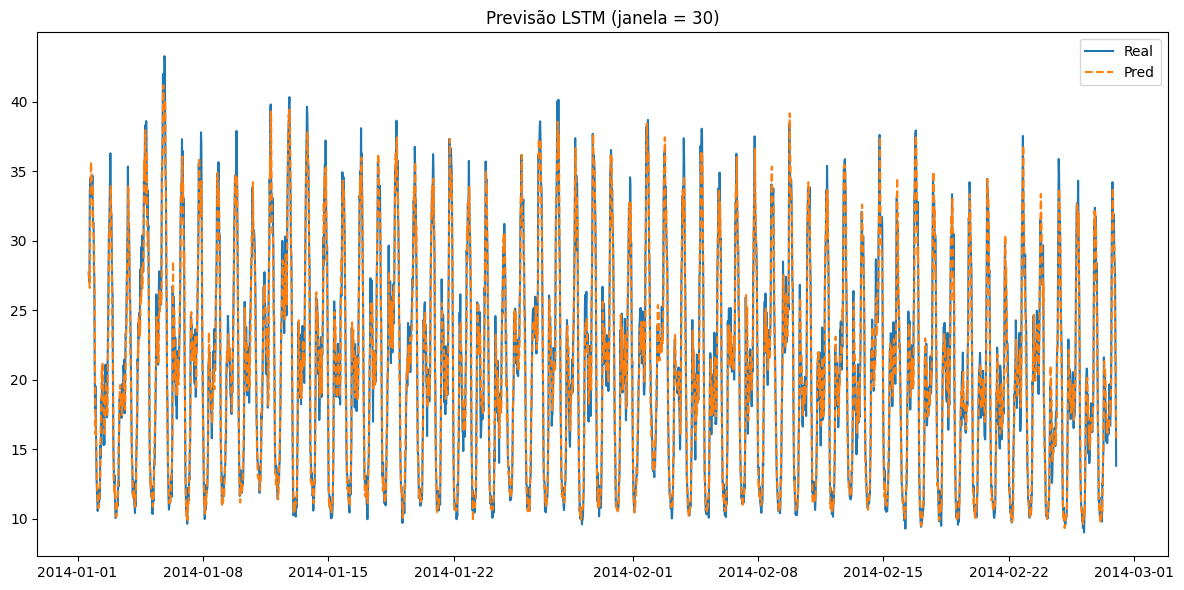

In [107]:
model.eval()
with torch.no_grad():
    pred_test = model(testX.to(device)).cpu().numpy()   
pred_test_inv = scaler.inverse_transform(pred_test)
testY_inv     = scaler.inverse_transform(testY.numpy())

plt.figure(figsize=(12, 6))
plt.plot(test.index[tamanho:],  testY_inv.ravel(), label='Real')
plt.plot(test.index[tamanho:],  pred_test_inv.ravel(), '--', label='Pred')
plt.title('Previsão LSTM (janela = 30)')
plt.legend()
plt.tight_layout()
plt.show()
